# Описание проекта

Я прохожу стажировку в отдел аналитики Яндекс.Афиши. Задание: помочь маркетологам оптимизировать маркетинговые затраты.

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:

- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Описание данных:

Таблица visits (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день


Для начала импортируем необходимые библиотеки и прочтем данные:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Создадим функцию, которая автоматизирует предварительный просмотр датафреймов и вывод информации о них, а также количество пропусков и дубликатов:

In [3]:
def first_look (df):
    print ('---------------- Первые 5 строк --------------------')
    display (df.head())
    print(' ')
    print(' ')
    print ('---------------- Типы данных --------------------')
    print (df.info())
    print(' ')
    print(' ')
    print ('---------------- Пропуски --------------------')
    count = 0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count =+1
    if count == 0:
        print ('Пропусков НЕТ')
    print(' ')
    print(' ')
    print ('---------------- Дубликаты --------------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print ('Дубликатов НЕТ')

Начнем с таблицы visits:

In [4]:
first_look(visits)

---------------- Первые 5 строк --------------------


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


 
 
---------------- Типы данных --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
 
 
---------------- Пропуски --------------------
Пропусков НЕТ
 
 
---------------- Дубликаты --------------------
Дубликатов НЕТ


Изменяем формат столбцов Start Ts и End Ts на дата-время

In [5]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format = '%Y-%m-%d %H:%M:%S')
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format = '%Y-%m-%d %H:%M:%S')

Переименуем названия столбцов:

In [6]:
visits.columns = ['device', 'session_end_ts', 'source_id', 'session_start_ts', 'uid']

In [7]:
visits.head()

,device,session_end_ts,source_id,session_start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [8]:
visits['device'] = visits['device'].astype('category')

Проверим, все ли даты, имеющиеся в нашей таблице, входят в промежуток времени, который нам нужно исследовать.

In [9]:
visits['session_start_ts'].min(), visits['session_start_ts'].max(), visits['session_end_ts'].min(), visits['session_end_ts'].max()

(Timestamp('2017-06-01 00:01:00'),
 Timestamp('2018-05-31 23:59:00'),
 Timestamp('2017-06-01 00:02:00'),
 Timestamp('2018-06-01 01:26:00'))

Таблица Orders:

In [10]:
first_look(orders)

---------------- Первые 5 строк --------------------


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


 
 
---------------- Типы данных --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
 
 
---------------- Пропуски --------------------
Пропусков НЕТ
 
 
---------------- Дубликаты --------------------
Дубликатов НЕТ


Изменим формат столбца Buy Ts на дата-время:

In [11]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format = '%Y-%m-%d %H:%M:%S')

Переименуем названия столбцов:

In [12]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [13]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Проверим, все ли даты, имеющиеся в нашей таблице, входят в промежуток времени, который нам нужно исследовать.

In [14]:
orders['buy_ts'].min(), orders['buy_ts'].max()

(Timestamp('2017-06-01 00:10:00'), Timestamp('2018-06-01 00:02:00'))

Таблица costs

In [15]:
first_look(costs)

---------------- Первые 5 строк --------------------


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


 
 
---------------- Типы данных --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
 
 
---------------- Пропуски --------------------
Пропусков НЕТ
 
 
---------------- Дубликаты --------------------
Дубликатов НЕТ


Изменим формат столбца dt на дата-время:

In [16]:
costs['dt'] = pd.to_datetime(costs['dt'])

Проверим, все ли даты, имеющиеся в нашей таблице, входят в промежуток времени, который нам нужно исследовать.

In [17]:
costs['dt'].min(), costs['dt'].max()

(Timestamp('2017-06-01 00:00:00'), Timestamp('2018-05-31 00:00:00'))

Все данные приведены к нужному формату, столбцы переименованы, пропусков и дубликатов не обнаружено. Приступаем к расчетам

## Продуктовые метрики

# Метрики DAU, WAU и MAU

Добавим столбцы с датой сессии, неделей и месяцем в таблицу visits

In [18]:
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['session_start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['session_start_ts'].dt.date

visits.head()

,device,session_end_ts,source_id,session_start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27


Посчитаем показатели DAU, WAU и MAU

In [19]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
wau = visits.groupby('session_week').agg({'uid': 'nunique'})
mau = visits.groupby('session_month').agg({'uid': 'nunique'})

In [20]:
print('DAU за весь период:', int(dau.mean()), 'пользователей')
print('WAU за весь период:', int(wau.mean()), 'пользователей')
print('MAU за весь период:', int(mau.mean()), 'пользователей')

DAU за весь период: 907 пользователей
WAU за весь период: 5724 пользователей
MAU за весь период: 23228 пользователей


Отобразим изменения метрик во времени на графиках:

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


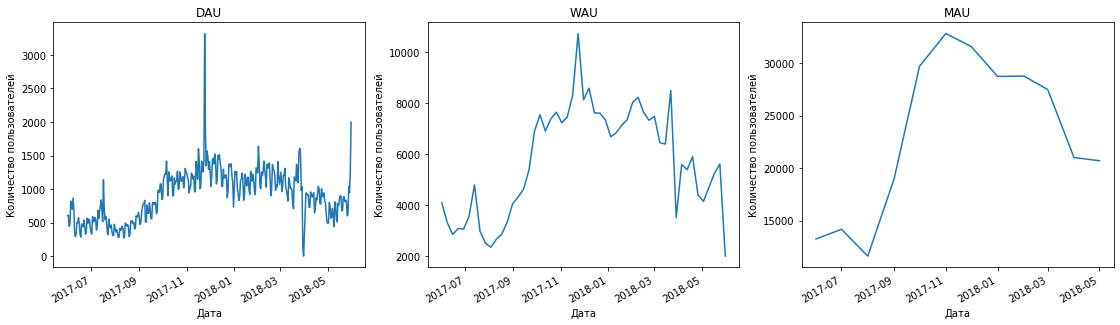

In [21]:
fig, ax = plt.subplots(1,3, figsize=(19,5))
ax[0].plot(dau)
ax[0].set(title = 'DAU', xlabel = 'Дата', ylabel = 'Количество пользователей')
ax[1].plot(wau)
ax[1].set(title = 'WAU', xlabel = 'Дата', ylabel = 'Количество пользователей')
ax[2].plot(mau)
ax[2].set(title = 'MAU', xlabel = 'Дата', ylabel = 'Количество пользователей')
fig.autofmt_xdate(rotation = 30)

plt.show()

Наблюдается всплеск DAU в конце ноября, а также падение в конце марта, посмотрим, в какой день это произошло.

In [22]:
dau['uid'].max()

3319

In [23]:
dau.loc[dau['uid']==3319]

,uid
session_date,
2017-11-24,3319


24 ноября 2017 года на сайт зашло 3319 пользователей. Возможно, была какая-то яркая премьера, или выстрелила реклама

In [24]:
dau['uid'].min()

1

In [25]:
dau.loc[dau['uid']==1]

,uid
session_date,
2018-03-31,1


31 марта на сайт зашел всего 1 пользователь. Полагаю, что это обусловлено какими-то техническими неполадками на сайте.

Рассчитаем Sticky Factor для оценки вовлеченности аудитории

In [26]:
sfm = (dau.mean() / mau.mean()) * 100
#за неделю
sfw = (dau.mean() / wau.mean()) * 100

In [27]:
print('Sticky factor за неделю: {:.2f} %' .format(float(sfw)))
print('Sticky factor за месяц: {:.2f} %' .format(float(sfm)))

Sticky factor за неделю: 15.86 %
Sticky factor за месяц: 3.91 %


Видим, что месячный SF оказался немногим ниже 4%, что является достаточно низким значением.

# Сколько сессий приходится на одного пользователя в день


Посчитаем среднее количество сессий на одного пользователя и построим график

In [28]:
sess_per_user = visits.groupby('session_date').agg({'uid':['count','nunique']})
sess_per_user.columns = ['n_sessions', 'n_users']
sess_per_user['sess_per_user'] = sess_per_user['n_sessions']/sess_per_user['n_users']

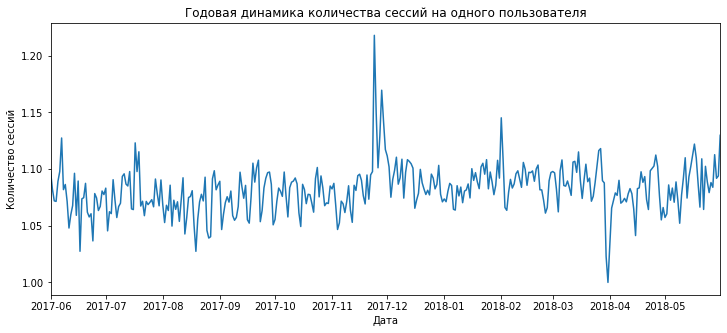

In [29]:
plt.figure(figsize=(12,5))

sess_per_user['sess_per_user'].plot(title = 'Годовая динамика количества сессий на одного пользователя')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')
plt.show()

In [30]:
print('В среднем на одного пользователя приходится {} сессий в день.'.format(round(sess_per_user['sess_per_user'].mean(),2)))

В среднем на одного пользователя приходится 1.08 сессий в день.


Как правило, пользователи посещают сайт один раз в день. На графике видим, что пик и спад этого показателя приходится на те же даты, когда произошли всплеск и падение DAU. Проверим, точно ли это.

In [31]:
sess_per_user['sess_per_user'].min()

1.0

In [32]:
sess_per_user.loc[sess_per_user['sess_per_user']==1]

,n_sessions,n_users,sess_per_user
session_date,,,
2018-03-31,1,1,1.0


In [33]:
sess_per_user['sess_per_user'].max()

1.2178366978005424

In [34]:
sess_per_user.loc[sess_per_user['sess_per_user']==1.2178366978005424]

,n_sessions,n_users,sess_per_user
session_date,,,
2017-11-24,4042,3319,1.217837


Так и есть, самые частые сессии были 24.11.2017, тогда же, когда сайт посетили наибольшее количество пользователей. А у единственного пользователя 31.03.2018 была одна сессия

# Сколько обычно длится одна сессия


Расчитаем длительность сессий в секундах и построим график распределения

In [35]:
visits['session_duration_sec'] = (visits['session_end_ts']- visits['session_start_ts']).dt.seconds
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

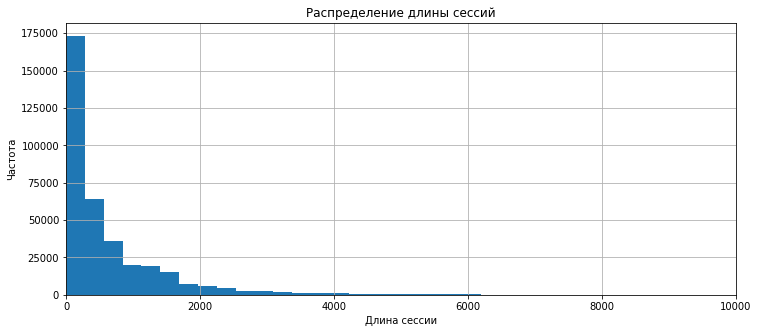

In [36]:
plt.figure(figsize = (12,5))
visits['session_duration_sec'].hist(bins = 300).set(title = 'Распределение длины сессий')
plt.xlabel('Длина сессии')
plt.ylabel('Частота')
plt.xlim(0,10000)
plt.show()

In [37]:
print('Средняя длительность сессии: {:.2f} сек'.format(visits['session_duration_sec'].mean()))
print('Медианная длительность сессии: {:.2f} сек'.format(visits['session_duration_sec'].median()))
print('Модальная длительность сессии: {:.2f} сек'.format(visits['session_duration_sec'].mode()[0]))

Средняя длительность сессии: 643.51 сек
Медианная длительность сессии: 300.00 сек
Модальная длительность сессии: 60.00 сек


Как мы видим по графику, в основном посетители проводят на сайте небольшое количество времени. Подавляющее большинство посетителей проводят на сайте всего около минуты.

# Рассчитываем Retention Rate, применяя когортный анализ

Для начала найдем дату первой сессии для каждого юзера (first_activity_date) и добавим ее в таблицу visits

In [38]:
first_activity_date = visits.groupby('uid')['session_date'].min()

In [39]:
first_activity_date.name = 'first_activity_date'
users_data = visits.merge(first_activity_date, on = 'uid')
users_data.head()

,device,session_end_ts,source_id,session_start_ts,uid,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09


Далее добавим месяц первой сессии и месяц нынешней сессии посетителя



In [40]:
users_data['first_activity_month'] = users_data['first_activity_date'].astype('datetime64[M]')
users_data['activity_month'] = users_data['session_date'].astype('datetime64[M]')
users_data.head()

,device,session_end_ts,source_id,session_start_ts,uid,session_month,session_week,session_date,session_duration_sec,first_activity_date,first_activity_month,activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01,2018-03-01


Посчитаем длительность жизни когорт (cohort_lifetime)

In [41]:
users_data['cohort_lifetime'] = users_data['activity_month'] - users_data['first_activity_month']
users_data['cohort_lifetime'] = users_data['cohort_lifetime'] / np.timedelta64(1,'M')
users_data['cohort_lifetime'] = users_data['cohort_lifetime'].round().astype('int')
users_data.head(10)

,device,session_end_ts,source_id,session_start_ts,uid,session_month,session_week,session_date,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01,2018-03-01,0
5,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27,2017-12-01,2017-12-01,0
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-01,2017-08-31,2017-09-03,60,2017-09-03,2017-09-01,2017-09-01,0
7,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-01,2017-10-26,2017-10-27,2520,2017-09-03,2017-09-01,2017-10-01,1
8,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-01,2017-08-31,2017-09-04,1140,2017-09-03,2017-09-01,2017-09-01,0
9,desktop,2017-10-28 00:04:00,3,2017-10-27 23:56:00,16007536194108375387,2017-10-01,2017-10-26,2017-10-27,480,2017-09-03,2017-09-01,2017-10-01,1


Сформируем таблицу с когортами и количеством уникальных посетителей в каждой.

In [42]:
cohorts = users_data.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Сформируем таблицу с количеством пользователей каждой когорты на первом месяце жизни когорты.

In [43]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Объединим таблицы cohorts и initial users и посчитаем retention

In [44]:
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on = 'first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


Сформируем сводную таблицу Retention Rate

In [45]:
retention_pivot = cohorts.pivot_table(
    index = 'first_activity_month', columns = 'cohort_lifetime', values = 'retention', aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для построения этой и последующих тепловых карт когортного анализа создадим функцию.

In [46]:
def heatmap(data, title, fmt, vmin, vmax):
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 9)
    plt.title(title)
    sns.heatmap(data, annot = True, linewidths = 1, linecolor = 'black', fmt = fmt,
               vmin = vmin, vmax = vmax, cmap = 'Reds');

In [47]:
def heatmap_yticks(data, title, fmt, vmin, vmax):
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 9)
    plt.title(title)
    sns.heatmap(data, annot = True, linewidths = 1, linecolor = 'black', fmt = fmt,
               vmin = vmin, vmax = vmax, cmap = 'Reds')
    ticklabels = [data.index[int(tick)].strftime('%Y-%m') for tick in ax.get_yticks()]
    ax.set_yticklabels(ticklabels);

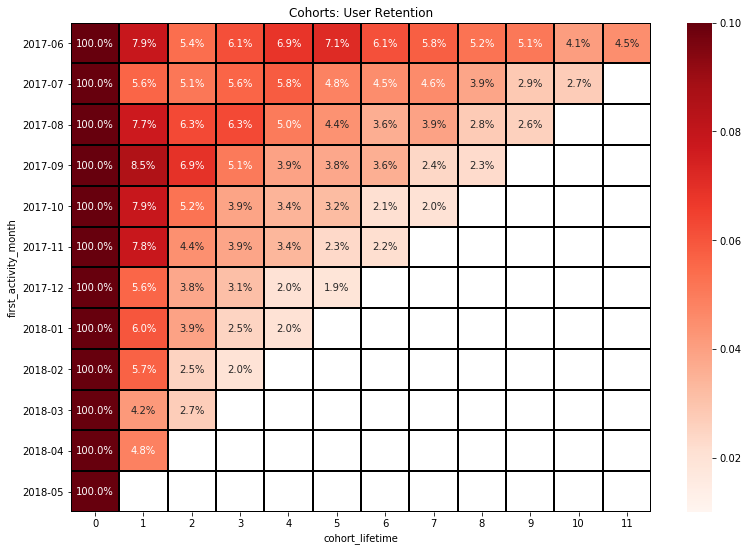

In [48]:
heatmap_yticks(retention_pivot, 'Cohorts: User Retention', '.1%', 0.01, 0.1)


Как мы видим, самая первая когорта, прожившая год, имеет самый большой Retention Rate по сравнению с другими когортами.

In [49]:
print('{:.1%}'.format(retention_pivot[1].mean()))

6.5%


Среднее значение Retention Rate за второй месяц жизни когорт - 6.5%. С каждым месяцем оно становится все меньше.

## Метрики электронной коммерции

# Сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

Cформируем таблицу, в которой объединим id пользователя, время начала сессии, источник первого посещения, а также стоимость привлечения одного пользователя, которую мы высчитаем.

In [50]:
costs = costs.rename(columns = {'dt': 'acquisition_date'})

users = visits.groupby('uid').agg({'session_start_ts':'min', 'source_id':'first', 'device':'first'}) 
users['acquisition_date'] = users['session_start_ts'].dt.date
users['acquisition_month'] = users['session_start_ts'].astype('datetime64[M]')
users = (users.reset_index().set_index(['source_id', 'acquisition_date'])
         .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))

user_cost = (users.groupby(['source_id', 'acquisition_date']).agg({'device': 'count', 'costs':'max'})
             .rename(columns = {'device': 'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acquisition_cost']], how = 'left')
users = users.reset_index().set_index('uid')[['session_start_ts', 'acquisition_date', 
                                              'acquisition_month', 'source_id', 'device', 'acquisition_cost']]
users = users.reset_index()
users.head()

,uid,session_start_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost
0,585738041899923335,2017-06-01 19:15:00,2017-06-01,2017-06-01,1,desktop,1.566667
1,618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.566667
2,1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.566667
3,1186757012633220834,2017-06-01 10:48:00,2017-06-01,2017-06-01,1,desktop,1.566667
4,1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.566667


Выведем таблицу первого заказа для каждого пользователя

In [51]:
orders_time = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
orders_time.head()

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Сформируем общуу таблицу пользователей и посчитаем разницу между временем первой покупки и временем первого посещения.

In [52]:
users_final = users.merge(orders, on = 'uid')
users_final['delta'] = (users_final['buy_ts'] - users_final['session_start_ts']) 
users_final

,uid,session_start_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,buy_ts,revenue,delta
0,585738041899923335,2017-06-01 19:15:00,2017-06-01,2017-06-01,1,desktop,1.566667,2017-06-01 22:08:00,0.15,0 days 02:53:00
1,1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.566667,2017-06-01 09:23:00,0.37,0 days 00:02:00
2,1186757012633220834,2017-06-01 10:48:00,2017-06-01,2017-06-01,1,desktop,1.566667,2017-06-05 13:02:00,2.75,4 days 02:14:00
3,1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.566667,2017-06-01 16:47:00,4.28,0 days 03:54:00
4,3520273333047097992,2017-06-01 20:08:00,2017-06-01,2017-06-01,1,desktop,1.566667,2017-06-01 20:35:00,0.24,0 days 00:27:00
...,...,...,...,...,...,...,...,...,...,...
50410,14350420740207733259,2018-05-31 10:15:00,2018-05-31,2018-05-01,10,desktop,0.174257,2018-05-31 10:15:00,25.67,0 days 00:00:00
50411,14350420740207733259,2018-05-31 10:15:00,2018-05-31,2018-05-01,10,desktop,0.174257,2018-05-31 11:08:00,18.33,0 days 00:53:00
50412,15116668155510764243,2018-05-31 22:47:00,2018-05-31,2018-05-01,10,desktop,0.174257,2018-05-31 22:50:00,2.44,0 days 00:03:00
50413,15576344609395725707,2018-05-31 23:35:00,2018-05-31,2018-05-01,10,desktop,0.174257,2018-05-31 23:40:00,2.26,0 days 00:05:00


Посмотрим на гистограмму распределения

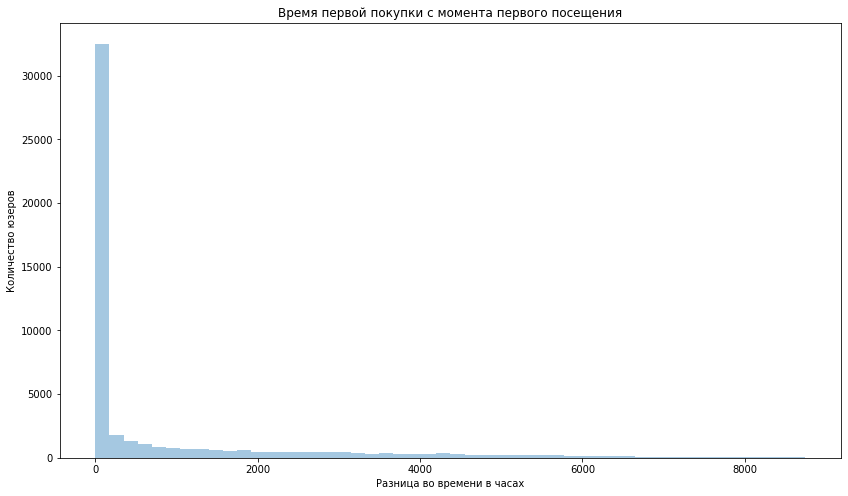

In [53]:
fig = plt.figure(figsize = (14, 8))
sns.distplot((users_final['delta'] / np.timedelta64(1,'h')), bins = 50, kde = False)
plt.xlabel('Разница во времени в часах')
plt.ylabel('Количество юзеров')
plt.title('Время первой покупки с момента первого посещения');

Посчитаем модальную разницу:

In [54]:
users_final['delta'].mode()


0   00:01:00
dtype: timedelta64[ns]

Подавляющее большинство пользователей совершают покупки на сайте быстро, в течение одной минуты.

# Среднее количество покупок на одного клиента


Рассчитаем среднее количество покупок за месяц. Добавим столбец с месяцем покупки в таблицу orders.

In [55]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


Создадим таблицу first_orders, в которой сгруппируем заказы по когортам в зависимости от первого заказа.

In [56]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders = first_orders.merge(users_final, on = 'uid')
first_orders['order_month'] = first_orders['buy_ts'].astype('datetime64[M]')
first_orders

,uid,first_order_month,session_start_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,buy_ts,revenue,delta,order_month
0,313578113262317,2018-01-01,2017-09-18 22:49:00,2017-09-18,2017-09-01,2,desktop,1.987692,2018-01-03 21:51:00,0.55,106 days 23:02:00,2018-01-01
1,1575281904278712,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01,10,touch,0.506316,2017-06-03 10:13:00,1.22,0 days 00:00:00,2017-06-01
2,1575281904278712,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01,10,touch,0.506316,2017-06-03 17:39:00,1.83,0 days 07:26:00,2017-06-01
3,2429014661409475,2017-10-01,2017-10-11 17:14:00,2017-10-11,2017-10-01,3,desktop,1.728446,2017-10-11 18:33:00,73.33,0 days 01:19:00,2017-10-01
4,2464366381792757,2018-01-01,2018-01-27 20:10:00,2018-01-27,2018-01-01,5,desktop,1.123088,2018-01-28 15:54:00,2.44,0 days 19:44:00,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
50410,18445407535914413204,2017-09-01,2017-09-22 23:48:00,2017-09-22,2017-09-01,3,desktop,1.967832,2017-09-24 23:48:00,0.24,2 days 00:00:00,2017-09-01
50411,18445407535914413204,2017-09-01,2017-09-22 23:48:00,2017-09-22,2017-09-01,3,desktop,1.967832,2017-09-25 15:56:00,0.12,2 days 16:08:00,2017-09-01
50412,18445601152732270159,2018-03-01,2017-08-07 11:51:00,2017-08-07,2017-08-01,2,desktop,1.168571,2018-03-26 22:54:00,4.22,231 days 11:03:00,2018-03-01
50413,18446156210226471712,2018-02-01,2017-11-07 10:01:00,2017-11-07,2017-11-01,3,desktop,1.938074,2018-02-18 19:34:00,9.78,103 days 09:33:00,2018-02-01


Определим размер когорт

In [57]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Сформируем таблицу с информацией по когортам, в которую добавим среднее количество заказов в месяц (mean), средний чек (avg_check) и возраст когорты (age)

In [58]:
cohorts = first_orders.groupby(['first_order_month','order_month']).agg(
    {'uid': 'nunique', 'revenue':['sum', 'count']}).reset_index()
cohorts.columns = ['first_order_month', 'order_month', 'uid', 'revenue_sum', 'buy_count']
cohorts['mean'] = cohorts['buy_count'] / cohorts['uid']
cohorts['avg_check'] = (cohorts['revenue_sum'] / cohorts['buy_count']).round(2)
cohorts['age'] = (cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')
cohorts['age'] = cohorts['age'].round().astype('int')

cohorts

,first_order_month,order_month,uid,revenue_sum,buy_count,mean,avg_check,age
0,2017-06-01,2017-06-01,2023,9557.49,2354,1.163618,4.06,0
1,2017-06-01,2017-07-01,61,981.82,177,2.901639,5.55,1
2,2017-06-01,2017-08-01,50,885.34,174,3.480000,5.09,2
3,2017-06-01,2017-09-01,54,1931.30,226,4.185185,8.55,3
4,2017-06-01,2017-10-01,88,2068.58,292,3.318182,7.08,4
...,...,...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,58,1114.87,176,3.034483,6.33,2
75,2018-04-01,2018-04-01,2276,10600.69,2495,1.096221,4.25,0
76,2018-04-01,2018-05-01,69,1209.92,195,2.826087,6.20,1
77,2018-05-01,2018-05-01,2988,13925.76,3249,1.087349,4.29,0


In [59]:
cohorts = cohorts.merge(cohort_sizes, on='first_order_month')

In [60]:
cohorts['orders_per_buyers']=cohorts['buy_count']/cohorts['n_buyers']

Сформируем сводную таблицу среднего числа покупок по когортам и их возрасту и построим тепловую карту.

In [61]:
cohorts_pivot = cohorts.pivot_table(
        index = 'first_order_month', 
        columns = 'age', 
        values = 'orders_per_buyers', 
        aggfunc = 'sum').cumsum(axis=1)
    
cohorts_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.25111,1.33712,1.44884,1.59318,1.70094,1.83737,1.92338,2.02818,2.10381,2.15126,2.19377
2017-07-01,1.136765,1.18877,1.25117,1.30525,1.34269,1.38534,1.41706,1.44306,1.47322,1.4857,1.51326,
2017-08-01,1.118978,1.19781,1.2708,1.32993,1.39197,1.43723,1.47299,1.52993,1.5635,1.59708,,
2017-09-01,1.136381,1.22123,1.28361,1.34715,1.37311,1.41534,1.45719,1.47888,1.50252,,,
2017-10-01,1.143779,1.21613,1.25346,1.28157,1.31129,1.33502,1.35484,1.38364,,,,
2017-11-01,1.179368,1.27665,1.32124,1.37295,1.40627,1.42073,1.44572,,,,,
2017-12-01,1.152635,1.21424,1.26032,1.30116,1.32078,1.34474,,,,,,
2018-01-01,1.121554,1.18796,1.2351,1.25408,1.2772,,,,,,,
2018-02-01,1.121611,1.18242,1.20515,1.22432,,,,,,,,


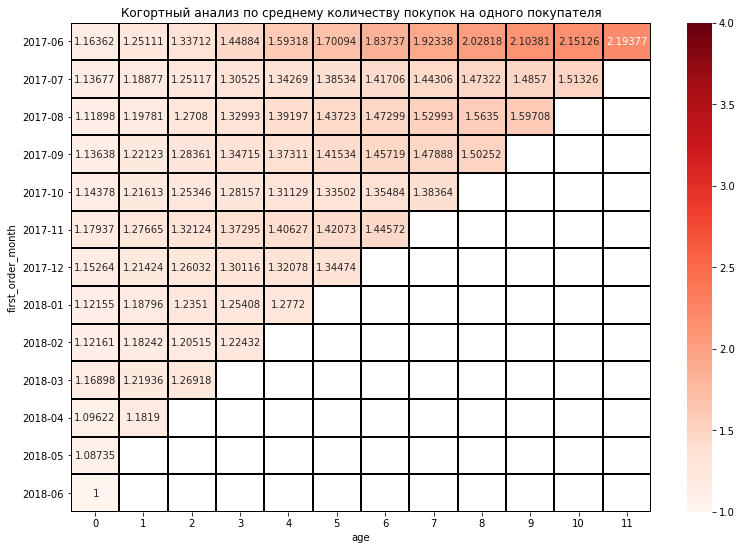

In [62]:
heatmap_yticks(cohorts_pivot, 'Когортный анализ по среднему количеству покупок на одного покупателя', '2g', 1, 4);

Посчитаем среднее количество покупок на одного покупателя по когортам

In [63]:
pd.DataFrame(cohorts_pivot.mean(axis = 1))

,0
first_order_month,
2017-06-01,1.727715
2017-07-01,1.358389
2017-08-01,1.391022
2017-09-01,1.357269
2017-10-01,1.284965
2017-11-01,1.346134
2017-12-01,1.265648
2018-01-01,1.215179
2018-02-01,1.183374


Как мы видим, как и в случае с Retention Rate, самая больше всего покупок на одного посетителя у первой когорты. Возможно, самым первым посетителям предоставлялись какие-то бонусы или особые условия, по-этому такой результат.

Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев

In [64]:
round(cohorts_pivot[5].mean(),2)

1.43

среднее количество покупок на одного покупателя за 6 месяцев составляет 1.43. 

# Cредний чек

Посчитаем средний чек по всем посетителям

In [65]:
round(orders['revenue'].mean(),2)

5.0

Средний чек составил 5 у.е.

Нарисуем динамику изменения среднего чека во времени

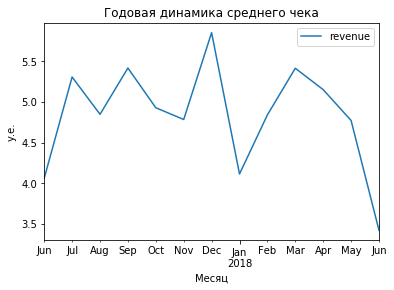

In [66]:
orders.pivot_table(index = 'order_month', values = 'revenue', aggfunc = 'mean').plot()
plt.title('Годовая динамика среднего чека')
plt.xlabel('Месяц')
plt.ylabel('у.е.')
plt.show()

Как мы видим, наибольший средний чек был в предновогодний период (конец ноября - декабрь), а наименьший - в летний период (конец мая - июль)

# LTV


Для расчета LTV по когортам объединим таблицы с размером когорт и информацией по когортам.

Найдем LTV и построим сводную таблицу

In [67]:
cohorts['ltv'] = cohorts['revenue_sum'] / cohorts['n_buyers']
    
ltv_pivot = cohorts.pivot_table(
        index = 'first_order_month', 
        columns = 'age', 
        values = 'ltv', 
        aggfunc = 'mean').round(2)

ltv_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


Рассчитаем среднее значение месячного LTV по всем когортам.

In [68]:
ltv_mean = pd.DataFrame(ltv_pivot.mean(axis=1)).round(2)
ltv_mean.columns = ['ltv_mean']
ltv_mean

,ltv_mean
first_order_month,
2017-06-01,0.99
2017-07-01,0.76
2017-08-01,0.85
2017-09-01,1.49
2017-10-01,0.80
2017-11-01,0.91
2017-12-01,1.28
2018-01-01,0.99
2018-02-01,1.15


Выведем когортный анализ с накапливаемым ltv

In [69]:
merged_ltv = ltv_pivot.cumsum(axis = 1).merge(ltv_mean, left_index = True, right_index = True)
merged_ltv.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11,ltv_mean
first_order_month,,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88,0.99
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,,0.76
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,,0.85
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,,1.49
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,,0.80
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,,0.91
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,,1.28
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,,0.99
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,,1.15


Взглянем на тепловую карту

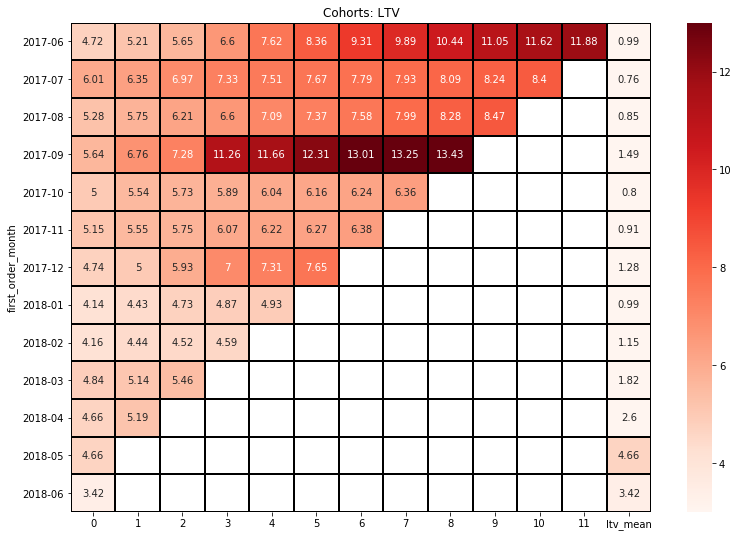

In [70]:
heatmap_yticks(merged_ltv, 'Cohorts: LTV', '2g', 3, 13)


Из когорт с возрастом более 6 месяцев, наибольший средний LTV у декабрьской и сентябрьской когорт. В сентябрьской когорте наблюдается особенно большой LTV после четвертого месяца

Рассчитаем средний LTV по когортам за 6 месяцев

In [71]:
round(merged_ltv[5].mean(),2)

7.97

Теперь расчитаем показатель LTV в зависимости от рекламных источников

Рассчитаем размеры групп по источникам рекламы.

In [72]:
cohort_source_sizes = first_orders.groupby('source_id').agg({'uid': 'nunique'}).reset_index()
cohort_source_sizes.columns = ['source_id', 'n_buyers']
cohort_source_sizes

,source_id,n_buyers
0,1,3743
1,2,4323
2,3,9138
3,4,9823
4,5,6839
5,7,1
6,9,1415
7,10,1241


Выведем сводную таблицу количества пользователей, прибыли и количества покупок по источникам.

In [73]:
cohorts_source = first_orders.groupby('source_id').agg(
    {'uid': 'nunique', 'revenue':['sum', 'count']}).reset_index()
cohorts_source.columns = ['source_id', 'uid', 'revenue_sum', 'buy_count']
cohorts_source

,source_id,uid,revenue_sum,buy_count
0,1,3743,38560.06,6679
1,2,4323,65152.26,7734
2,3,9138,44317.68,10941
3,4,9823,52479.75,12246
4,5,6839,40357.91,9310
5,7,1,1.22,1
6,9,1415,7076.98,2053
7,10,1241,4111.34,1451


Объединим таблицы cohort_source_sizes и cohorts_source

In [74]:
report_source = pd.merge(cohort_source_sizes, cohorts_source, on = 'source_id')

report_source

,source_id,n_buyers,uid,revenue_sum,buy_count
0,1,3743,3743,38560.06,6679
1,2,4323,4323,65152.26,7734
2,3,9138,9138,44317.68,10941
3,4,9823,9823,52479.75,12246
4,5,6839,6839,40357.91,9310
5,7,1,1,1.22,1
6,9,1415,1415,7076.98,2053
7,10,1241,1241,4111.34,1451


Рассчитаем накопительный LTV по различным источникам рекламы и построим столбчатую диаграмму.

In [75]:
report_source['ltv'] = report_source['revenue_sum'] / report_source['n_buyers']
    
source_ltv_pivot = report_source.pivot_table(
        index = 'source_id', 
        values = 'ltv', 
        aggfunc = 'mean').round(2)
    
source_ltv_pivot = source_ltv_pivot.reset_index()
source_ltv_pivot

,source_id,ltv
0,1,10.30
1,2,15.07
2,3,4.85
3,4,5.34
4,5,5.90
5,7,1.22
6,9,5.00
7,10,3.31


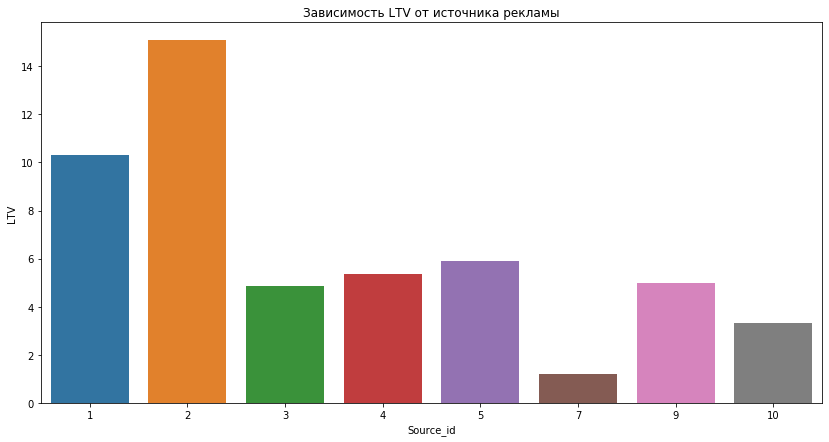

In [76]:
fig = plt.figure(figsize = (14, 7))
sns.barplot(x = 'source_id', y = 'ltv', data = source_ltv_pivot, palette = 'tab10')
plt.xlabel('Source_id')
plt.ylabel('LTV')
plt.title('Зависимость LTV от источника рекламы');

Как мы видим, второй и первый источники являются наиболее привлекательные с точки зрения прибыли с одного клиента. Однако, чтобы точно судить об эффективности рекламных источников, необходимо знать показатель САС.

## Маркетинговые метрики

# Общие расходы

Рассчитаем расходы на маркетинг по месяцам

In [77]:
costs['month'] = costs['acquisition_date'].astype('datetime64[M]')
monthly_costs = costs.groupby('month').agg({'costs':'sum'}).reset_index()
monthly_revenue = pd.DataFrame(orders.groupby('order_month')['revenue'].sum()).reset_index()
monthly_revenue.columns = ['month', 'revenue']
monthly_costs = monthly_costs.merge(monthly_revenue, on = 'month')
monthly_costs['romi'] = monthly_costs['revenue'] / monthly_costs['costs']
monthly_costs

,month,costs,revenue,romi
0,2017-06-01,18015.00,9557.49,0.530530
1,2017-07-01,18240.59,12539.47,0.687449
2,2017-08-01,14790.54,8758.78,0.592188
3,2017-09-01,24368.91,18345.51,0.752824
4,2017-10-01,36322.88,27987.70,0.770525
5,2017-11-01,37907.88,27069.93,0.714098
6,2017-12-01,38315.35,36388.60,0.949713
7,2018-01-01,33518.52,19417.13,0.579296
8,2018-02-01,32723.03,25560.54,0.781118
9,2018-03-01,30415.27,28834.59,0.948030


Больше всего затрат на маркетинг - в средних месяцах (к концу года), прибыль, казалось бы тоже выше, но окупаемости нет. Далее рассмотрим ROMI по когортам и по источникам рекламы, а пока найдем суммарные расходы на маркетинг за все время.

In [78]:
monthly_costs['costs'].sum().round(2)


329131.62

Сгруппируем расходы по источникам.

In [79]:
source_costs = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
source_costs

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [80]:
source_costs_month  = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()
source_costs_month  = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()


Визуализруем изменение расходов на рекламу по разным источникам во времени

In [81]:
source_costs_month.pivot_table(index = 'month',columns='source_id', values = 'costs', aggfunc = 'sum')

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


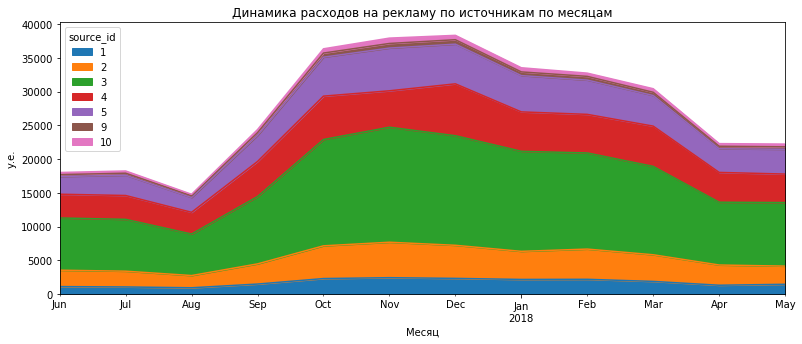

In [82]:
source_costs_month.pivot_table(index = 'month',columns='source_id', values = 'costs', aggfunc = 'sum').plot.area(figsize =(13,5))
plt.title('Динамика расходов на рекламу по источникам по месяцам')
plt.xlabel('Месяц')
plt.ylabel('у.е.')
plt.show()

Как мы видим, самый затратный источник - третий. 

# CAC

Посчитаем CAC одного покупателя для каждого источника, используя уже полученные таблицы

In [83]:
costs_merged = pd.merge(source_costs, cohort_source_sizes, on = 'source_id', how = 'outer').sort_values(by = 'source_id')
costs_merged['cac'] = costs_merged['costs'] / costs_merged['n_buyers']
costs_fin = pd.merge(costs_merged, source_ltv_pivot, on = 'source_id')
costs_fin['romi'] = costs_fin['ltv'] / costs_fin['cac']
costs_fin = costs_fin.sort_values(by = ['source_id'], ascending = True)
costs_fin.round(2).head()

,source_id,costs,n_buyers,cac,ltv,romi
0,1,20833.27,3743,5.57,10.30,1.85
1,2,42806.04,4323,9.90,15.07,1.52
2,3,141321.63,9138,15.47,4.85,0.31
3,4,61073.60,9823,6.22,5.34,0.86
4,5,51757.10,6839,7.57,5.90,0.78


Визуализируем зависимость CAC от источника рекламы.

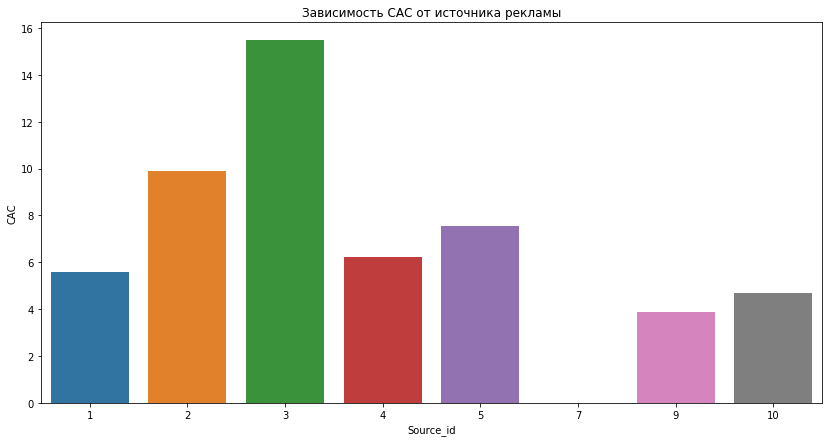

In [84]:
fig = plt.figure(figsize = (14, 7))
sns.barplot(x = 'source_id', y = 'cac', data = costs_fin, palette = 'tab10')
plt.xlabel('Source_id')
plt.ylabel('CAC')
plt.title('Зависимость CAC от источника рекламы');

Создадим сводную таблицу зависимости расходов на маркетинг от месяца

In [85]:
source_monthly_costs = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()
source_monthly_costs.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Посмотрим на изменение САС во времени в разрезе источников

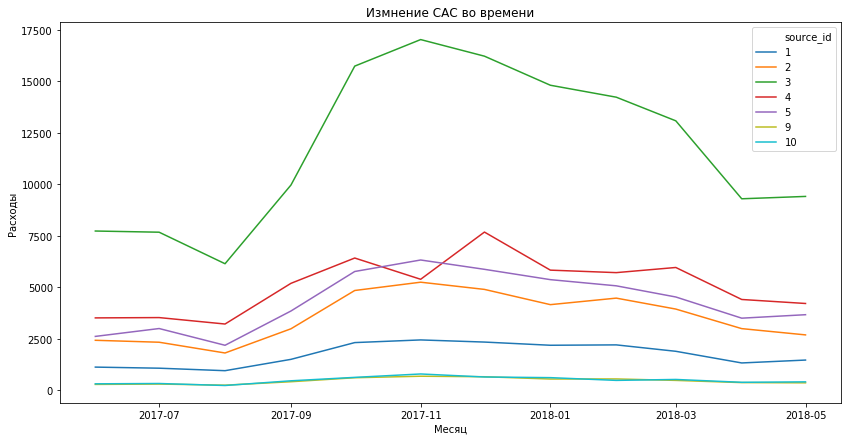

In [86]:
fig = plt.figure(figsize = (14, 7))
sns.lineplot(data = source_monthly_costs, x = 'month', y = 'costs', hue = 'source_id', legend = 'full', palette = 'tab10')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Измнение CAC во времени');

Как мы видим, стоимость привлечения одного клиента оказалась самой большой для источника №3, а самой маленькой для источников № 10, 9 и 1

Посчитаем средний САС за все время

In [87]:
cac = round(costs_merged['costs'].sum() / costs_merged['n_buyers'].sum(),2)

In [88]:
print('Общий средний САС по всему проекту:', cac)

Общий средний САС по всему проекту: 9.01


# Расчет показателя возврата инвестиций ROMI



Объединим датафрейм report, полученный при расчете ltv, с датафреймом monthly_costs и рассчитаем CAC для каждой когорты

In [89]:
report_new = pd.merge(cohorts, monthly_costs, left_on = 'first_order_month', right_on = 'month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,order_month,uid,revenue_sum,buy_count,mean,avg_check,age,n_buyers,orders_per_buyers,ltv,month,costs,revenue,romi,cac
0,2017-06-01,2017-06-01,2023,9557.49,2354,1.163618,4.06,0,2023,1.163618,4.724414,2017-06-01,18015.0,9557.49,0.53053,8.905091
1,2017-06-01,2017-07-01,61,981.82,177,2.901639,5.55,1,2023,0.087494,0.485329,2017-06-01,18015.0,9557.49,0.53053,8.905091
2,2017-06-01,2017-08-01,50,885.34,174,3.480000,5.09,2,2023,0.086011,0.437637,2017-06-01,18015.0,9557.49,0.53053,8.905091
3,2017-06-01,2017-09-01,54,1931.30,226,4.185185,8.55,3,2023,0.111715,0.954671,2017-06-01,18015.0,9557.49,0.53053,8.905091
4,2017-06-01,2017-10-01,88,2068.58,292,3.318182,7.08,4,2023,0.144340,1.022531,2017-06-01,18015.0,9557.49,0.53053,8.905091


Выведем график зависимости ROMI от источника рекламы.

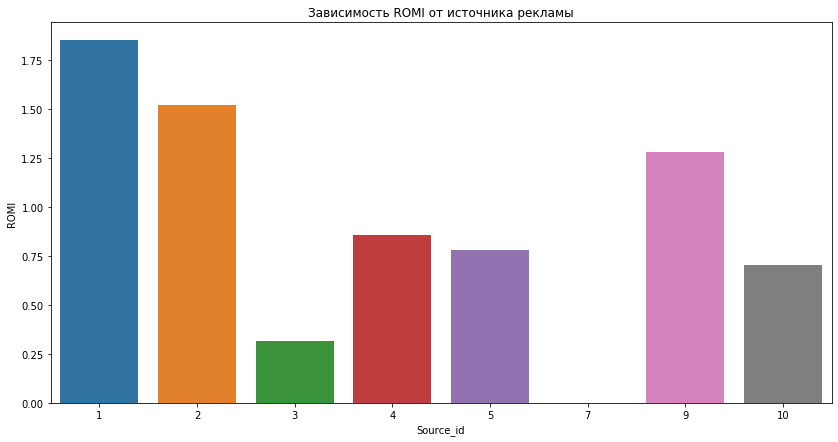

In [90]:
fig = plt.figure(figsize = (14, 7))
sns.barplot(x = 'source_id', y = 'romi', data = costs_fin, palette = 'tab10')
plt.xlabel('Source_id')
plt.ylabel('ROMI')
plt.title('Зависимость ROMI от источника рекламы');


Как мы видим, окупаемыми являются три рекламных источника: 1, 2, 9. Самый невыгодный - третий источник, который является самым затратным, но приносящий совсем немного выручки.

Теперь рассчитаем накопительный ROMI для каждой когорты.

In [91]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
pivot_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

final_romi = pivot_romi.cumsum(axis=1).round(2)
final_romi

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь вычислим средние значения ROMI по длительности жизни

In [92]:
mean_romi = pd.DataFrame(pivot_romi.cumsum(axis=1).mean(axis=0)).round(2)
mean_romi.columns = ['mean']
mean_romi = mean_romi.T
mean_romi

age,0,1,2,3,4,5,6,7,8,9,10,11
mean,0.54,0.58,0.63,0.72,0.78,0.86,0.9,0.97,1.05,0.96,1.09,1.33


Выведем когортный анализ по ROMI

In [93]:
merged_romi = pd.concat([final_romi, mean_romi], axis = 0)
merged_romi.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01 00:00:00,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01 00:00:00,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01 00:00:00,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01 00:00:00,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01 00:00:00,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01 00:00:00,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01 00:00:00,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01 00:00:00,0.46,0.49,0.5,0.51,,,,,,,,
2018-03-01 00:00:00,0.56,0.6,0.63,,,,,,,,,


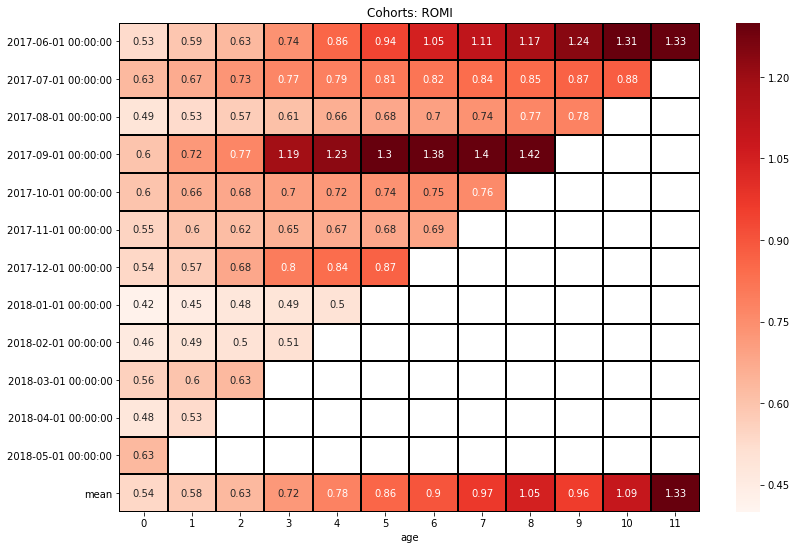

In [94]:
heatmap(merged_romi, 'Cohorts: ROMI', '2g', 0.4, 1.3)

Как мы видим, быстрее всего окупились сентябрьстая и самая первая, июньская когорты. Также близка к окупаемости декабрьская когорта.  

Теперь рассчитаем ROMI с разбивкой по типу источников рекламы, с которых пользователи заходили впервые. Для этого создадим соответствующую функцию.

In [95]:
def romi(name, title):
    
    ''' Функция для вывода таблицы ROMI и тепловой карты для различных рекламных источников'''

    user_src = users[users['source_id'] == name]
    costs_src = pd.DataFrame(user_src.groupby(['acquisition_month'])['acquisition_cost'].sum()).reset_index()
        
    first_orders_src = first_orders[first_orders['source_id'] == name]

    cohort_sizes_src = first_orders_src.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes_src.columns = ['first_order_month', 'n_buyers']

    cohorts_src = first_orders_src.groupby(['first_order_month','order_month']).agg(
        {'uid': 'nunique', 'revenue':['sum', 'count']}).reset_index()
    cohorts_src.columns = ['first_order_month', 'order_month', 'uid', 'revenue_sum', 'buy_count']
    
    cohorts_src['age'] = (cohorts_src['order_month'] - cohorts_src['first_order_month']) / np.timedelta64(1, 'M')
    cohorts_src['age'] = cohorts_src['age'].round().astype('int')

    report_src = pd.merge(cohort_sizes_src, cohorts_src, on = 'first_order_month')
    margin_rate = 1
    report_src['gp'] = report_src['revenue_sum'] * margin_rate

    report_src['ltv'] = report_src['gp'] / report_src['n_buyers']
    report_new_romi = pd.merge(report_src, costs_src, left_on = 'first_order_month', right_on = 'acquisition_month')
    report_new_romi['cac'] = report_new_romi['acquisition_cost'] / report_new_romi['n_buyers']
    report_new_romi.head()

    output_cac_romi = report_new_romi.pivot_table(
            index='first_order_month', 
            values='cac', 
            aggfunc='mean')

    output_cac_romi.reset_index()

    report_new_romi['romi'] = report_new_romi['ltv'] / report_new_romi['cac']
    pivot_romi_src = report_new_romi.pivot_table(
            index='first_order_month', 
            columns='age', 
            values='romi', 
            aggfunc='mean')
    
    final_romi_src = pivot_romi_src.cumsum(axis=1).round(2)
    
    mean_romi_src = pd.DataFrame(pivot_romi_src.cumsum(axis=1).mean(axis=0)).round(2)
    mean_romi_src.columns = ['mean']
    mean_romi_src = mean_romi_src.T
    
    merged_romi_src = pd.concat([final_romi_src, mean_romi_src], axis = 0)
    

    heatmap(merged_romi_src, title, '2g', 0.7, 6)

In [96]:
source_ids ={1,2,3,4,5,9,10}

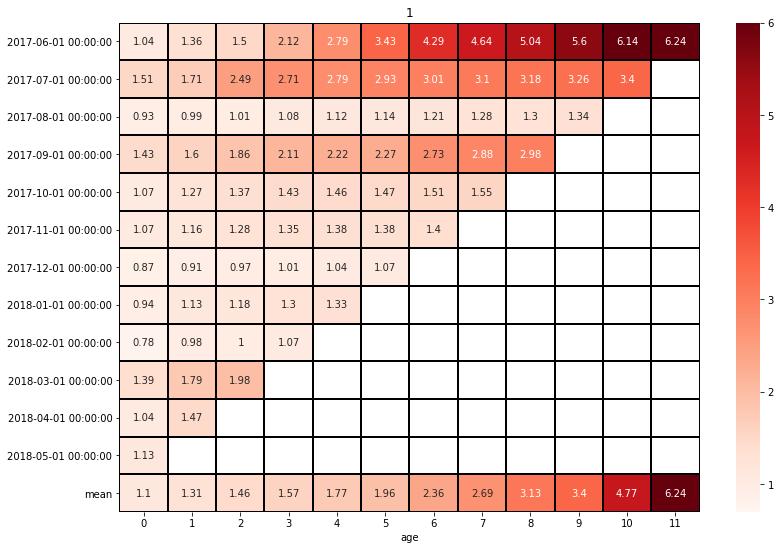

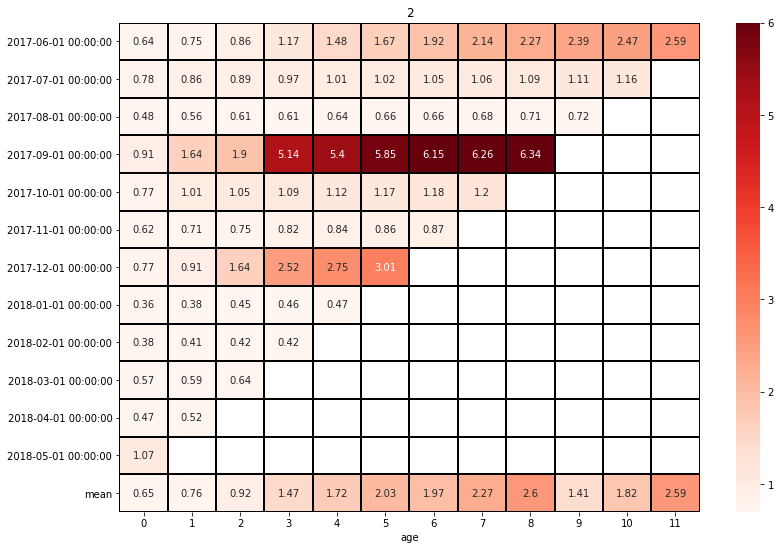

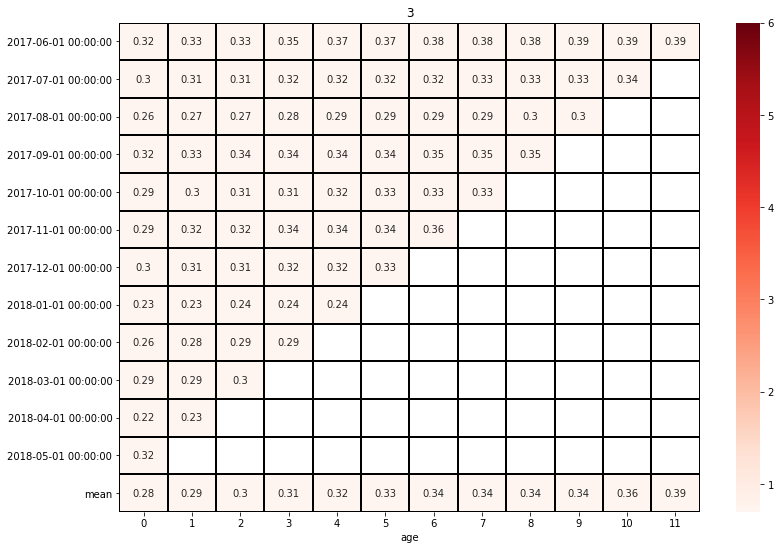

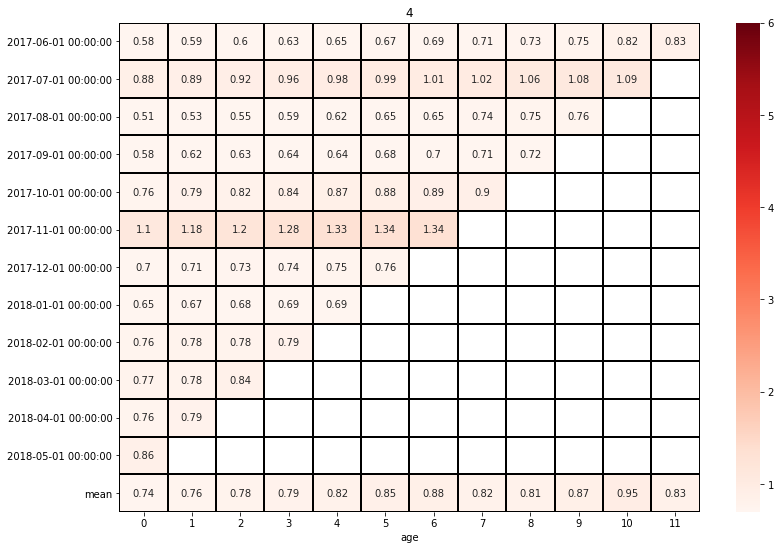

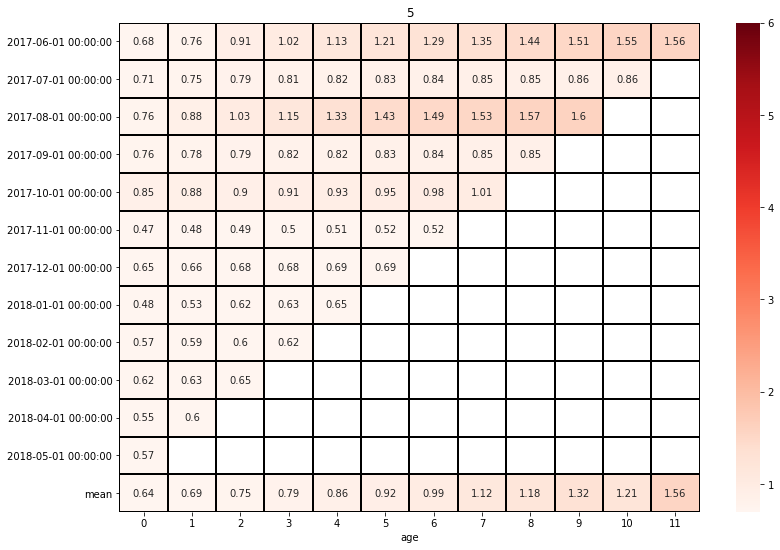

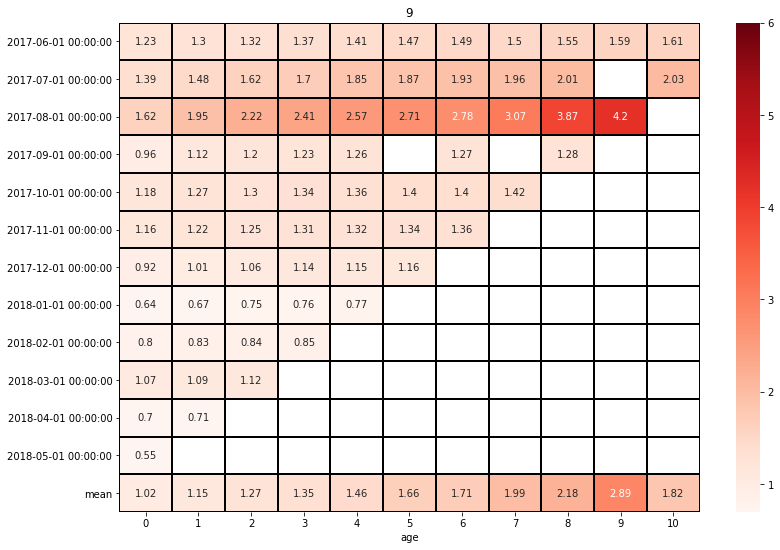

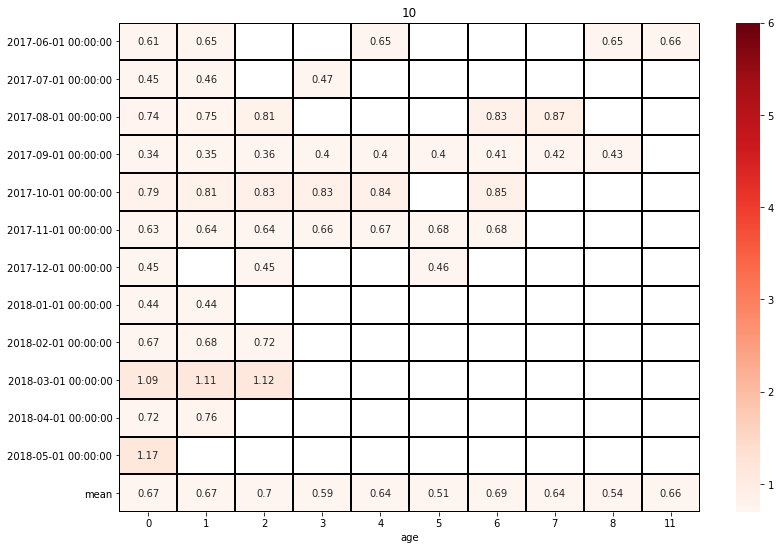

In [97]:
for name in source_ids:
    romi(name, name)

Как и при общем расчете, самыми эффективными являются 3 источника: 1, 2 и 9. При когортном анализе стало видно, что второй источник обладает высоким средним ROMI из-за успешной сентябрьской когорты. Источник под номером 9 окупается быстрее (с первого месяца). Десятый источник использовался нерегулярно. При этом в среднем 9 источник быстро выходит на окупаемость, думаю, стоит больше внимания уделить ему.

В случае с ROMI метод dt.strftime() почему-то не сработал, поэтому метки оси у для тепловых карт ROMI я оставил прежними.

## Общие выводы и рекомендации

Мной была проведена работа по исследованию анализа продуктов, продаж и маркетинговых затрат Яндекс.Афиши для оптимизации маркетинговых вложений.

1. Исходя из проведенного анализа, наиболее перспективными являются 1, 2 и 9 источники трафика, у которых самые высокие ROMI и самый низкий САС. Третий источник трафика использовался неэффективно и убыточно. Девятый источник использовался немного, но он показал себя быстро окупающимся, маркетологам стоит обратить на него внимание.
2. - Как правило, пользователи заходят на сайт не более одного раза в день, на сайте проводят около одной минуты. Retention rate данного сайта достаточно низок. 
  - Количество покупок за период сильно зависит от когорты, как мы видим, самая "покупающая" - первая когорта. Видимо, как и в случае с Retention Rate, это обусловлено какими-то особыми условиями и бонусами, которые были предоставлены первым пользователям. Или же это эффект новизны. Рекомендация -  улучшить таким же образом показатели других когорт.
  - Также чаще всего покупают пользователи первой когорты (июнь 2017), скорее всего это связано с какими-то бонусами или специальными программами для первых зарегистрировавшихся. Больше трех покупок в среднем на пользователя этой когорты, в то время, как по остальным когортам этот показатель - в районе 1,5-1,8.
  - Из когорт с возрастом более 6 месяцев, наибольший средний LTV у декабрьской и сентябрьской когорт. 
  - Самыми низкими затратами на привлечение покупателей обладают 1 и 9 источники, стоит их рекомендовать маркетологам для дальнейшего развития.
  - За промежуток нашей выборки окупились две когорты. Быстрее всего окупилась когорта сентября 2017г. - за 4 месяца, первая когорта (июнь 2017г.) окупилась за 7 месяцев. Остальные когорты к маю 2018г. не окупились, но когорта декабря 2017г. близка к этому.
  - Самыми выгодными являюся 1,2 и 9 источники рекламы. Разница между LTV и CAC для них наибольшая, ROMI также высок. Можно рекомендовать тратить маркетологам больше денег на эти источники. Источник по номером 3 очень дорогой, обладает низким ROMI, но приносит довольно много клиентов. Возможно, стоит отказаться от него.

3. Самыми перспективными оказались самая первая и четвертая, сентябрьская когорты.



